In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import kruskal
from statsmodels.stats.multitest import fdrcorrection

from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
import sklearn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import cross_val_score

from scipy.stats import zscore

from sklearn.pipeline import make_pipeline

import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
from sklearn.metrics import confusion_matrix

### 0. Perform Kruskal-Wallis to sort features by significance

In [8]:
def select_features_kruskal_Wallis(df, num_feat=6670, feat='plv', sel_feat=20):
    """Takes a df with many features. Performs Kruskal-Wallis Test. Performs FDR test.
    feat: ['plv', 'aec', 'foof', 'cc', 'pw', 'atm'] _eign _betw 
    """
    # p values for Kruskal-Wallis test
    classes = list(np.unique(df['class'].values)) # list of classes 
    p_vals = {f'{feat}_{i}': kruskal(*[df[df['class'] == cls].iloc[:, i] 
                                for cls in classes]).pvalue for i in range(num_feat)}
    pvals = np.array(list(p_vals.values())) # num_feat p-values

    # FDR correction
    pvals_corrected = fdrcorrection(pvals)[1]
    pvals_fdr = {f'{feat}_{i}': pvals_corrected[i] for i in range(0, num_feat)}
    top_features = [x[0] for x in sorted(pvals_fdr.items(), key=lambda x:x[1])[:sel_feat]]
    
    # Rename columns 
    cols = [f'{feat}_{i}' for i in range(0, num_feat)]
    cols = cols + ['ID', 'class']
    df.columns = cols
    
    df = df[top_features + ['class']]
    
    return df

In [9]:
reduced_datasets = ['df_plv_flat.csv']#, 'df_aec_flat.csv', 'df_atm.csv', 'df_cc.csv']
sel_features_40 = dict()

for ds in reduced_datasets:
    print(f'Selecting features for {ds}')
    df = pd.read_csv("../data/flatten_datasets/" + ds)
        
    sel_features_40[ds] = select_features_kruskal_Wallis(df, feat=ds[3:6], num_feat=len(df.columns)-2,
                                           sel_feat=40)

Selecting features for df_plv_flat.csv


### 1. Perform ML algorithms with Repetitive K-fold to evaluate average Confusion Matrices

In [10]:
param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen']} 

param_grid_svm = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
               'kernel': ['rbf', 'poly']}

def eval_num_features_lda(df: pd.DataFrame, num_feat: int, metric_optim: str): #-> Tuple[dict, List[np.ndarray]]:
    """Without feature scaling here.
    metric_optim : ['balanced_accuracy', 'accuracy']
    """
    
    X = df.drop('class', axis=1)
    X = X.iloc[:, :num_feat] # select only (num_feat) top features
    le = LabelEncoder()
    y = le.fit_transform(df['class'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, shuffle=True)
    
    cv_grid_search = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=43) # for GridSearch CV
    grid_lda = GridSearchCV(LinearDiscriminantAnalysis(), param_grid_lda, 
                            scoring=metric_optim, cv=cv_grid_search) 
    
    grid_lda.fit(X_train, y_train)
    
    clf_lda = grid_lda.best_estimator_
    
    all_bal_accs, all_accs, all_f1w, all_f1m = list(), list(), list(), list()
    cv_eval = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=17)  # for evaluative CV
    metrics = dict()
    confusion_matrices = []  # Store confusion matrices
    
    scoring_metrics = [metric_optim]#, 'accuracy', 'f1_weighted', 'f1_macro']
    scores_balacc = list()
    for metric in scoring_metrics:
        scores_lda = cross_val_score(clf_lda, X_test, y_test, cv=cv_eval, scoring=metric)
        metrics['LDA_' + metric] = scores_lda.mean()
        if metric == metric_optim:
            scores_balacc = scores_lda
        
        # Collect confusion matrices during each fold
        fold_confusion_matrices = []
        for train_index, test_index in cv_eval.split(X_test, y_test):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            
            clf_lda.fit(X_train_fold, y_train_fold)
            y_pred = clf_lda.predict(X_test_fold)
            fold_confusion_matrices.append(confusion_matrix(y_test_fold, y_pred))
        
        confusion_matrices.append(fold_confusion_matrices)

    return metrics, scores_balacc, confusion_matrices, le


def eval_num_features_svc(df: pd.DataFrame, num_feat: int, metric_optim: str) -> dict:
    """Without feature scaling here.
    metric_optim : accuracy metric to be optimized 
    """
    
    X = df.drop('class', axis=1)
    X = X.iloc[:, :num_feat] # select only (num_feat) top features
    le = LabelEncoder()
    y = le.fit_transform(df['class'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, shuffle=True)
    
    cv_grid_search = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=43) # for GridSearch CV
    grid_svm = GridSearchCV(SVC(random_state=102), param_grid_svm, 
                            scoring=metric_optim, cv=cv_grid_search, 
                           refit=True, verbose=0)
    grid_svm.fit(X_train, y_train)
    
    clf_svm = grid_svm.best_estimator_
    
    all_bal_accs, all_accs, all_f1w, all_f1m = list(), list(), list(), list()
    cv_eval = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=17)  # for evaluative CV
    metrics = dict()
    confusion_matrices = []
    
    scoring_metrics = [metric_optim]# ', 'accuracy', 'f1_weighted', 'f1_macro']
    scores_balacc = list()
    for metric in scoring_metrics:
        scores_svm = cross_val_score(clf_svm, X_test, y_test, cv=cv_eval, scoring=metric)
        metrics['SVM_' + metric] = scores_svm.mean()
        
        if metric == metric_optim:
            scores_balacc = scores_svm
            
        # Collect confusion matrices during each fold
        fold_confusion_matrices = []
        for train_index, test_index in cv_eval.split(X_test, y_test):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            
            clf_svm.fit(X_train_fold, y_train_fold)
            y_pred = clf_svm.predict(X_test_fold)
            fold_confusion_matrices.append(confusion_matrix(y_test_fold, y_pred))
        
        confusion_matrices.append(fold_confusion_matrices)

    return metrics, scores_balacc, confusion_matrices, le


def eval_num_features_xgb(df: pd.DataFrame, num_feat: int) -> dict:
    """Without feature scaling here."""
    
    X = df.drop('class', axis=1)
    X = X.iloc[:, :num_feat] # select only (num_feat) top features
    le = LabelEncoder()
    y = le.fit_transform(df['class'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True)
    
    clf_xgb = XGBClassifier(objective='multi:softmax')
    
    all_bal_accs, all_accs, all_f1w, all_f1m = list(), list(), list(), list()
    cv_eval = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=17)  # for evaluative CV
    metrics = dict()
    
    scoring_metrics = ['balanced_accuracy', 'accuracy', 'f1_weighted', 'f1_macro']
    scores_balacc = list()
    for metric in scoring_metrics:
        scores_xgb = cross_val_score(clf_xgb, X, y, cv=cv_eval, scoring=metric)
        metrics['XGB_' + metric] = scores_xgb.mean()
        if metric == 'balanced_accuracy':
            scores_balacc = scores_xgb
    return metrics, scores_balacc

['MCI' 'MS' 'PD_off' 'SLA']
balanced_accuracy equals 0.6714583333333334


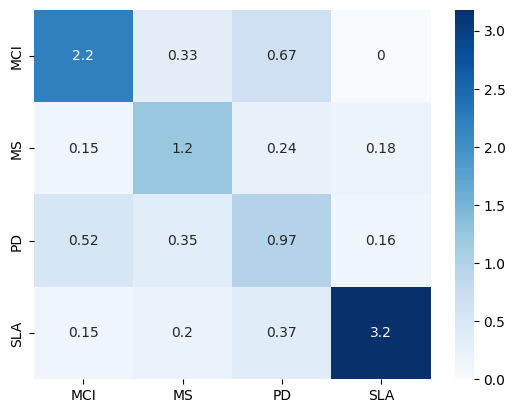

In [11]:
metric_to_optimize = 'balanced_accuracy'

metrics, scores, conf_mats, l_enc = eval_num_features_lda(sel_features_40['df_plv_flat.csv'], 
                                                          num_feat=34, metric_optim=metric_to_optimize)

print(l_enc.classes_)

avg_mat = np.mean(np.array(conf_mats)[0], axis=0)

print(f'{metric_to_optimize} equals {np.mean(scores)}')

sns.heatmap(avg_mat, cmap='Blues', annot=avg_mat, 
           xticklabels=['MCI', 'MS', 'PD', 'SLA'], yticklabels=['MCI', 'MS', 'PD', 'SLA']);

plt.savefig("../figures/conf_matrix.png", dpi=600)

In [12]:
np.diag(avg_mat) / np.sum(avg_mat, axis=0)

array([0.72847682, 0.58293839, 0.43111111, 0.90340909])